In [2]:
import pandas as pd
import numpy as np
df = pd.read_excel('../DataSet/E Commerce Dataset.xlsx', sheet_name='E Comm')
df.head()
df.select_dtypes(exclude=np.number).columns
df.describe().T.style.bar(subset=['mean']).background_gradient(subset=['std','50%','max'])
data_info = df.info()
data_head = df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [3]:
# Data Cleaning
# Check the percentage of missing values in each column
data = df
missing_values = data.isnull().sum() / len(data) * 100

# Display columns with missing values
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Impute missing values based on the data type
# For numerical columns, use mean imputation
numerical_columns = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 
                     'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']
for col in numerical_columns:
    data[col].fillna(data[col].mean(), inplace=True)

# Verify if missing values are handled
remaining_missing_values = data.isnull().sum().sum()

missing_values, remaining_missing_values

(DaySinceLastOrder              5.452931
 OrderAmountHikeFromlastYear    4.706927
 Tenure                         4.689165
 OrderCount                     4.582593
 CouponUsed                     4.547069
 HourSpendOnApp                 4.529307
 WarehouseToHome                4.458259
 dtype: float64,
 0)

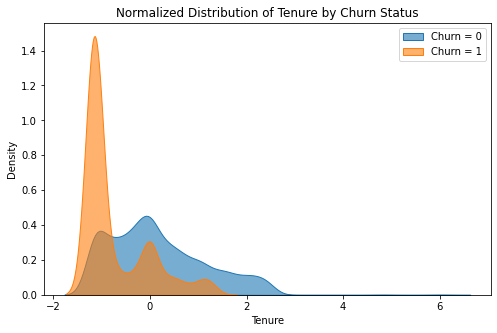

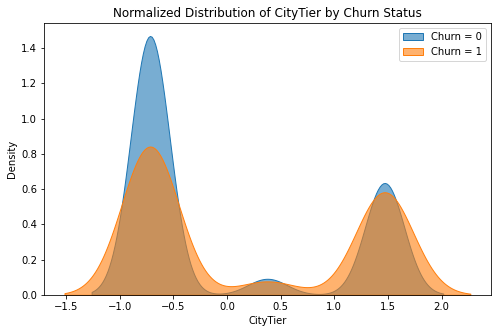

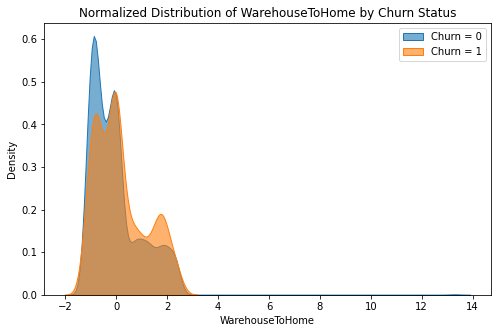

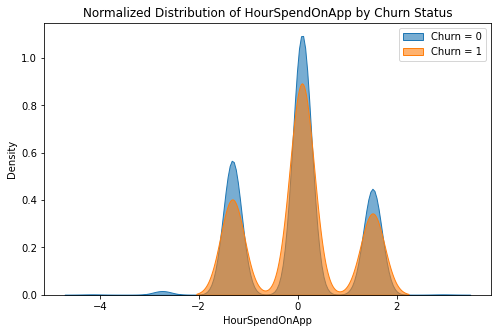

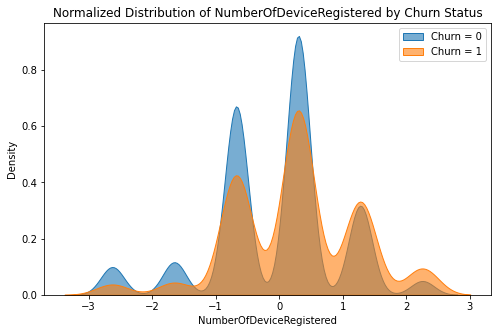

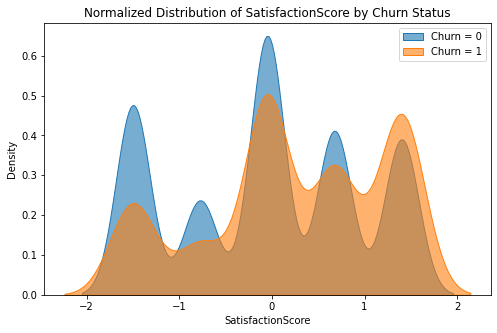

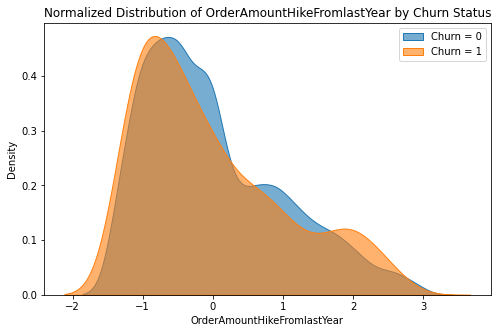

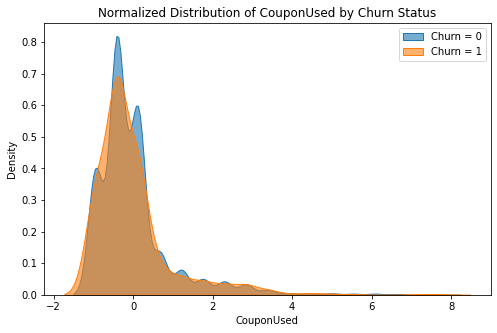

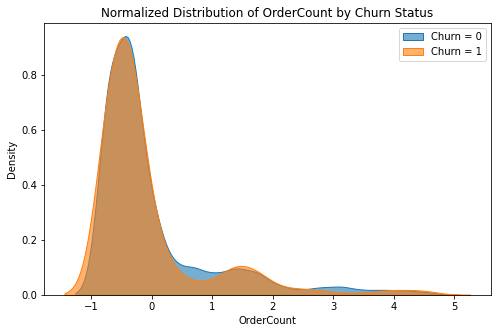

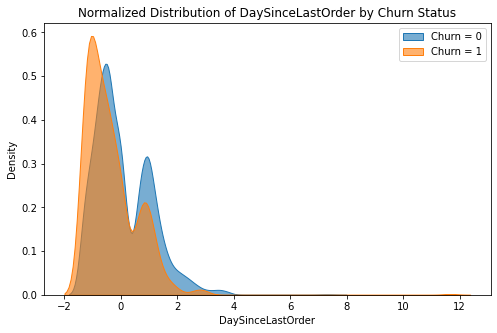

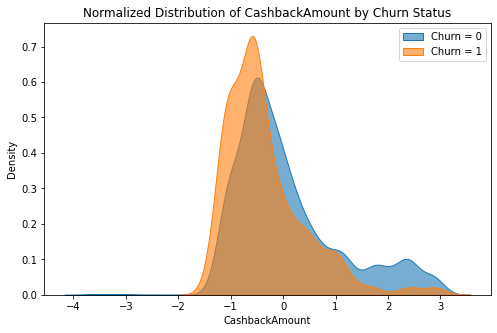

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
numerical_features = [
    'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 
    'NumberOfDeviceRegistered', 'SatisfactionScore', 'OrderAmountHikeFromlastYear', 
    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'
]

# Initialize scaler
scaler = StandardScaler()

# Normalize the numerical features
normalized_data = data.copy()
normalized_data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Ensure all numerical values are valid (handle invalid values like NaNs or infinities)
for feature in numerical_features:
    normalized_data[feature] = pd.to_numeric(normalized_data[feature], errors='coerce')
    normalized_data[feature].fillna(0, inplace=True)  # Replace invalid values with 0

# Visualize normalized features grouped by Churn
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=normalized_data[normalized_data['Churn'] == 0][feature], 
                label='Churn = 0', fill=True, alpha=0.6)
    sns.kdeplot(data=normalized_data[normalized_data['Churn'] == 1][feature], 
                label='Churn = 1', fill=True, alpha=0.6)
    plt.title(f'Normalized Distribution of {feature} by Churn Status')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Define features and target variable
features = [
    'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 
    'NumberOfDeviceRegistered', 'SatisfactionScore', 'OrderAmountHikeFromlastYear', 
    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'
]
X = normalized_data[features]
y = normalized_data['Churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = logreg.score(X_test, y_test)
classification_report_result = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Output the evaluation metrics
accuracy, classification_report_result, roc_auc

(0.7291296625222025,
 '              precision    recall  f1-score   support\n\n           0       0.94      0.72      0.82       941\n           1       0.35      0.75      0.48       185\n\n    accuracy                           0.73      1126\n   macro avg       0.64      0.74      0.65      1126\nweighted avg       0.84      0.73      0.76      1126\n',
 0.8130798173306143)

In [12]:
feature_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

feature_coefficients

,Feature,Coefficient
5,SatisfactionScore,0.321260
4,NumberOfDeviceRegistered,0.303489
8,OrderCount,0.295468
1,CityTier,0.240450
2,WarehouseToHome,0.200696
7,CouponUsed,0.142001
6,OrderAmountHikeFromlastYear,-0.061258
3,HourSpendOnApp,-0.098916
10,CashbackAmount,-0.244096
9,DaySinceLastOrder,-0.492890


In [8]:
print("Positive Influence on Churn: Higher SatisfactionScore, NumberOfDeviceRegistered, and OrderCount increase the likelihood of churn.These features may suggest overuse or a saturation point with the service.Negative Influence on Churn: Tenure has the largest negative coefficient, indicating longer association reduces churn.Fewer Days Since Last Order and higher CashbackAmount are also linked to lower churn. Neutral or Low Influence:Features like OrderAmountHikeFromlastYear and HourSpendOnApp have smaller coefficients, indicating they are less predictive of churn.")

Positive Influence on Churn: Higher SatisfactionScore, NumberOfDeviceRegistered, and OrderCount increase the likelihood of churn.These features may suggest overuse or a saturation point with the service.Negative Influence on Churn: Tenure has the largest negative coefficient, indicating longer association reduces churn.Fewer Days Since Last Order and higher CashbackAmount are also linked to lower churn. Neutral or Low Influence:Features like OrderAmountHikeFromlastYear and HourSpendOnApp have smaller coefficients, indicating they are less predictive of churn.


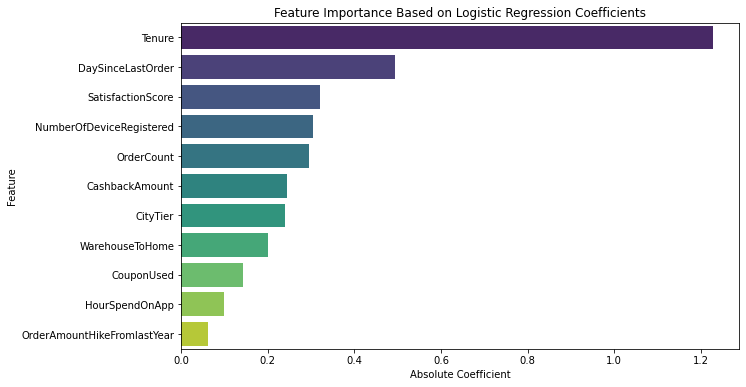

,Feature,Coefficient,Absolute_Coefficient
0,Tenure,-1.227301,1.227301
9,DaySinceLastOrder,-0.492890,0.492890
5,SatisfactionScore,0.321260,0.321260
4,NumberOfDeviceRegistered,0.303489,0.303489
8,OrderCount,0.295468,0.295468
10,CashbackAmount,-0.244096,0.244096
1,CityTier,0.240450,0.240450
2,WarehouseToHome,0.200696,0.200696
7,CouponUsed,0.142001,0.142001
3,HourSpendOnApp,-0.098916,0.098916


In [9]:
# Calculate absolute coefficients
feature_importance = feature_coefficients.copy()
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()

# Sort features by absolute coefficient
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Absolute_Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance Based on Logistic Regression Coefficients')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

# Display the detailed feature importance table
feature_importance

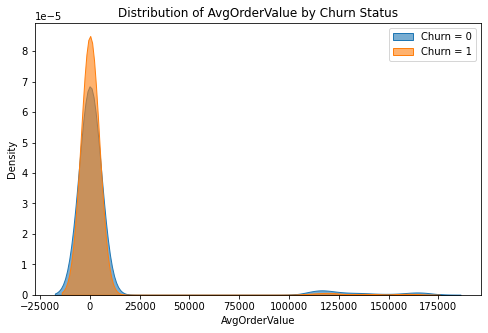

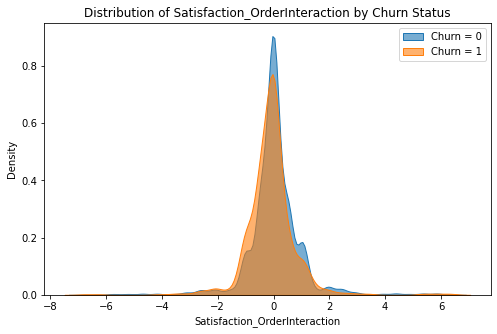

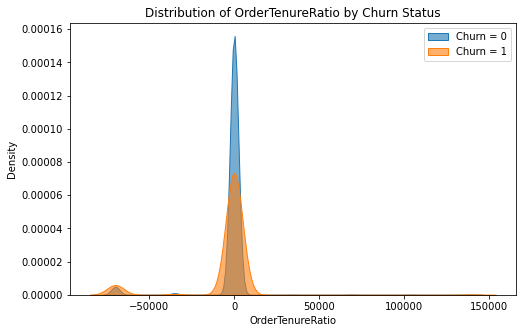

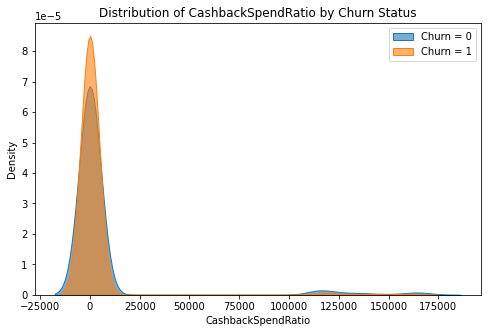

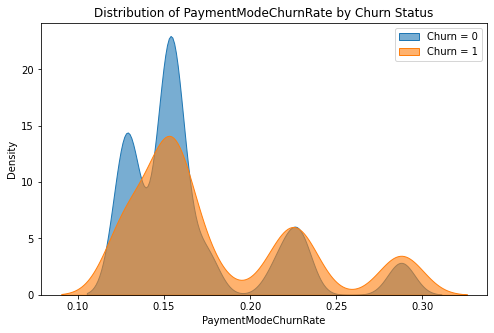

In [7]:
# Feature Engineering
normalized_data['AvgOrderValue'] = normalized_data['CashbackAmount'] / (normalized_data['OrderCount'] + 1e-5)

# Interaction Features
normalized_data['Satisfaction_OrderInteraction'] = normalized_data['SatisfactionScore'] * normalized_data['OrderCount']

# Ratios
normalized_data['OrderTenureRatio'] = normalized_data['OrderCount'] / (normalized_data['Tenure'] + 1e-5)
normalized_data['CashbackSpendRatio'] = normalized_data['CashbackAmount'] / (normalized_data['OrderCount'] + 1e-5)

# Payment Mode Churn Rate
payment_churn_rates = normalized_data.groupby('PreferredPaymentMode')['Churn'].mean()
normalized_data['PaymentModeChurnRate'] = normalized_data['PreferredPaymentMode'].map(payment_churn_rates)

# Check the new features
new_features = ['AvgOrderValue', 'Satisfaction_OrderInteraction', 'OrderTenureRatio', 
                'CashbackSpendRatio', 'PaymentModeChurnRate']
normalized_data[new_features].head()
for feature in new_features:
    normalized_data[feature] = pd.to_numeric(normalized_data[feature], errors='coerce')
    normalized_data[feature].fillna(0, inplace=True)  # Replace invalid values with 0

# Re-attempt visualizations
for feature in new_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=normalized_data[normalized_data['Churn'] == 0][feature], 
                label='Churn = 0', fill=True, alpha=0.6)
    sns.kdeplot(data=normalized_data[normalized_data['Churn'] == 1][feature], 
                label='Churn = 1', fill=True, alpha=0.6)
    plt.title(f'Distribution of {feature} by Churn Status')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Define features and target variable
features = [
    'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 
    'NumberOfDeviceRegistered', 'SatisfactionScore', 'OrderAmountHikeFromlastYear', 
    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'PaymentModeChurnRate'
] 
X = normalized_data[features]
y = normalized_data['Churn']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = logreg.score(X_test, y_test)
classification_report_result = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Output the evaluation metrics
accuracy, classification_report_result, roc_auc

(0.7255772646536413,
 '              precision    recall  f1-score   support\n\n           0       0.94      0.72      0.81       941\n           1       0.34      0.75      0.47       185\n\n    accuracy                           0.73      1126\n   macro avg       0.64      0.73      0.64      1126\nweighted avg       0.84      0.73      0.76      1126\n',
 0.8181980067208549)

In [9]:
feature_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

feature_coefficients

,Feature,Coefficient
11,PaymentModeChurnRate,2.190251
5,SatisfactionScore,0.320835
4,NumberOfDeviceRegistered,0.302292
8,OrderCount,0.300654
1,CityTier,0.217518
2,WarehouseToHome,0.202169
7,CouponUsed,0.140703
6,OrderAmountHikeFromlastYear,-0.060654
3,HourSpendOnApp,-0.093793
10,CashbackAmount,-0.223365
